# Trabalho 3 de Introdução à Computação Visual
## Detecção de Captcha
Intergrantes: \
Gabriel Franco Jallais - 2021031890 \\
Henrique Daniel de Sousa - 2021031912 \\
Jorge Augusto de Lima e Silva - 2021032005 \\
\
O trabalho consiste em: a partir do banco de dados fornecido, implementar um método de prever quais letras estão contidas em um determinado Captcha. \\
A abordagem escolhida consiste em segmentar a imagem, encontrando as posições candidatas a serem letras e, em seguida, passar essas regiões da imagem como entrada para uma Rede Neural Convolucional, a qual realizará a tarefa de classificar o segmento da imagem entre uma das 26 letras ou 10 números.

## Bibliotecas Necessárias

In [ ]:
# !pip install numpy
# !pip install cv2
# !pip install os
# !pip install matplotlib
# !pip install math
# !pip install imutils
# !pip install keras
# !pip install sklearn

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
from imutils import paths
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

## Configuração da forma de acesso aos dados que serão usados para o treinamento

In [ ]:
# Parent Directory path
os.mkdir('/content/caracteres_treinamento')
parent_dir = "/content/caracteres_treinamento"
  
# Path
for i in range(48, 58):
  directory = chr(i)
  path = os.path.join(parent_dir, directory)
  os.mkdir(path)

for i in range(65, 91):
  directory = chr(i)
  path = os.path.join(parent_dir, directory)
  os.mkdir(path)

In [ ]:
# Parent Directory path
os.mkdir('/content/caracteres_validacao')
parent_dir = "/content/caracteres_validacao"
  
# Path
for i in range(48, 58):
  directory = chr(i)
  path = os.path.join(parent_dir, directory)
  os.mkdir(path)

for i in range(65, 91):
  directory = chr(i)
  path = os.path.join(parent_dir, directory)
  os.mkdir(path)

In [ ]:
# Parent Directory path
os.mkdir('/content/caracteres_teste')
parent_dir = "/content/caracteres_teste"
  
# Path
for i in range(48, 58):
  directory = chr(i)
  path = os.path.join(parent_dir, directory)
  os.mkdir(path)

for i in range(65, 91):
  directory = chr(i)
  path = os.path.join(parent_dir, directory)
  os.mkdir(path)

In [ ]:
#Importando arquivos do Drive
#->Adaptar para seu proprio diretório ou criar um diretório no Google Drive com mesmos nomes

from google.colab import drive
drive.mount('/content/drive')

#diretório
PWD = 'dados/CAPTCHA-10k/'
# exemplo: PWD = './data/fashion_mnist_sample/'

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/TP3/dados.zip > /dev/null

dados/CAPTCHA-10k/treinamento/000010.jpg


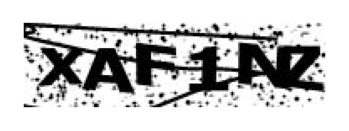

In [ ]:
image_name = PWD+"treinamento/000010.jpg"
print(image_name)
img = cv2.imread(image_name,0)
img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255,255,255])
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

#Tratamento da Imagem
A imagem passa por um pré-processamento, visando tornar seu conteúdo mais fácil de ser compreendido pela rede. Inicialmente, foi adicionado um padding na imagem, uma vez que, durante o treinamento, foi observado que o método escolhido para encontrar as regiões de interesse tinha dificuldade de identificar letras que estavam coladas na borda da imagem, portanto, uma camada de píxeis brancos foi adicionada ao redor da imagem, permitindo assim que o método identificasse regiões que não identificava anteriormente.



Agora com a imagem extendida, é necessário remover um pouco do ruído presente nela. Para isso, a função threshold é chamada, a trata uma parte considerável dos pontos que podem ser vistos ao fundo da imagem, mas, ao mesmo tempo, deia as letras com pequenos furos em sua superfície. É importante observar que este método não é muito eficaz na remoção do ruído na forma de linhas.

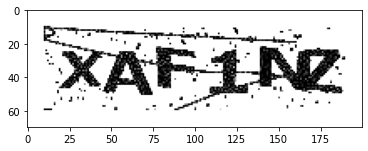

In [ ]:
_ , img_tratada = cv2.threshold(img, 30,255,cv2.THRESH_TRUNC or cv2.THRESH_OTSU)
plt.imshow(img_tratada, cmap='gray')

Para corrigir o problema das letras pontilhadas, foi passado o filtro da mediana na imagem, tornando as letras mais sólidas e, removendo ainda mais do ruído em forma de pontos no fundo da imagem. Também foi observado que este filtro fez com que os ruídos em forma de linhas fosse segmentado em partes onde  a linha era muito fina.

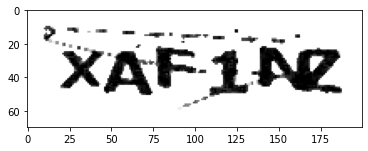

In [ ]:
blur = cv2.medianBlur(img_tratada, 3)
plt.imshow(blur, cmap='gray')

Em seguida, a imagem é convertida de 255 tons de cinza para 2, uma vez que o principal fator avaliado na hora de se classificar uma letra é seu formato, e não as diferenças entre seus tons de cinza.

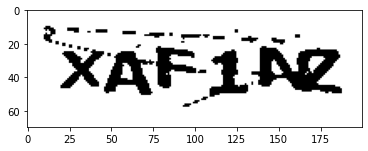

In [ ]:
img_j = cv2.adaptiveThreshold(blur, 100, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 2)
plt.imshow(img_j, cmap='gray')

Como forma de reduzir ainda o ruído da imagem, o método threshold é chamado novamente, removendo ainda mais ruído do fundo da imagem. \
\
Em seguida, os métodos dilatate foi chamado para tratar um problema que surgiu na parte de sugestão de áreas de interesse: duas letras estão muito coladas e são reconhecidas como apenas uma, como é o caso do N e do Z na imagem mostrada. \\
\
Com este método, por mais que grandes diferenças não possam ser vistas no caso do NZ mostrado, caso as letras não estiverem tão coladas quanto essas, o método é capaz de separá-las completamente.

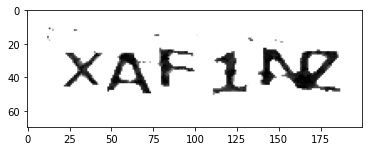

In [ ]:
image = cv2.blur(blur, (1, 1))
ret, image = cv2.threshold(image, 90, 255, cv2.THRESH_TRUNC)
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (4,3))
image = cv2.dilate(image, element)
plt.imshow(image, cmap='gray')

Por fim, percorre-se os píxeis da imagem e, se estes não forem claros o suficiente, são tranformados em 0, o que resulta nos objetos tendo uma cor mais sólida.

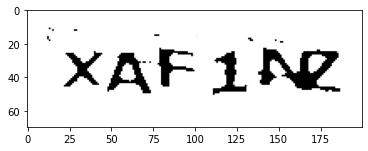

In [ ]:
for x in range(image.shape[0]):
  for y in range(image.shape[1]):
    if image[x][y] < 25:
      image[x][y] = 0
plt.imshow(image, cmap='gray')

# Encontrar Bounding Boxes
Uma vez que já realizamos o pré-processamento da imagem, iniciamos a parte de encontrar as regiões de interesse para a classificação, i. e., encontrar regiões onde provavelmente existe uma letra.

A função findContours foi utilizada para encontrar as bounding boxes.
Como esta retorna muitas bounding boxes que não são relevantes, é feita uma filtragem de quais são realmente interessantes, verificando as bounding boxes tem o tamanho e formato que podem conter uma letra. \\
\
Como discutido na parte da remoção de ruído, existem letras que estão coladas uma na outra, então, no caso da largura de uma bounding box ser muito maior do que a altura desta, a bounding box é dividida em duas, assumindo que esta representa duas letras que estão muito próximas ao invés de somente uma.

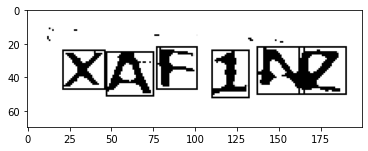

In [ ]:
contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
img_final = image

letter_image_regions = []
list_temp = []


for c in contours:
    rect = cv2.boundingRect(c)
    x, y, w, h = rect
    area = cv2.contourArea(c)
    if area > 115 and area < 3000 and h > 15 and w > 10:
      list_temp.append(rect)

for c in list_temp:
    for d in list_temp:
      if c[0] < d[0] and c[0] + c[2] > d[0] + d[2]:
        list_temp.remove(d)

for i in range(len(list_temp)):
    x, y, w, h = list_temp[i]

    if w > h*1.2:
      largura = int(w/(w/h))
      inicial = x
      
      for i in range(math.ceil(w/h)):
        
       
          cv2.rectangle(img_final,(inicial,y), (inicial+largura,y+h),(0,255,0),1)
          letter_image_regions.append([inicial,y,largura,h])

          inicial += int(w/math.ceil(w/h))

    else:
      cv2.rectangle(img_final,(x,y),(x+w,y+h),(0,255,0),1)
      letter_image_regions.append([x, y , w, h])
plt.imshow(img_final, cmap='gray')

Com as bounding boxes encontradas, a imagem contida por elas é transormada em uma imagem própria, e não mais uma parte da imagem original.

In [ ]:
letter_image_regions = sorted(letter_image_regions, key = lambda x : x[0])
print(letter_image_regions)

for i in range(1, len(letter_image_regions)):
  if i > 1 and i < len(letter_image_regions) -1:
    if letter_image_regions[i][0] < (letter_image_regions[i-1][0] + letter_image_regions[i-1][2]):
      if (letter_image_regions[i][0] + letter_image_regions[i][2]) > letter_image_regions[i+1][0]:
        letter_image_regions[i][0] = letter_image_regions[i-1][0] + letter_image_regions[i-1][2]
        letter_image_regions[i][2] = 30
      if letter_image_regions[i][0] + letter_image_regions[i][2] <= letter_image_regions[i-1][0] + letter_image_regions[i-1][2] \
          or letter_image_regions[i][2] <= 10 or letter_image_regions[i][0] + letter_image_regions[i][2] > 190:
        letter_image_regions.remove(letter_image_regions[i])

for i in range(1, len(letter_image_regions)):
  if i < len(letter_image_regions) -1:
    if letter_image_regions[i][0] > letter_image_regions[i+1][0]:
      letter_image_regions.remove(letter_image_regions[i+1])
    if letter_image_regions[i][0] + letter_image_regions[i][2] <= letter_image_regions[i-1][0] + letter_image_regions[i-1][2] + 3 \
          or letter_image_regions[i][2] <= 10 or letter_image_regions[i][0] + letter_image_regions[i][2] > 190:
        letter_image_regions.remove(letter_image_regions[i])


# for i in range(len(letter_image_regions)):

#   print((letter_image_regions[i][2] * letter_image_regions[i][3]))
#   if( (letter_image_regions[i][2] * letter_image_regions[i][3]) > 700):
    
#     letter_image_regions.remove(letter_image_regions[i])


print(letter_image_regions)
images = []

for letter_bounding_box in letter_image_regions:

  x,y,w,h = letter_bounding_box

  letter_image = image[y : y+h , x : x+w]
  images.append(letter_image)

[[21, 24, 25, 23], [47, 25, 28, 26], [77, 22, 24, 25], [110, 24, 22, 28], [137, 22, 28, 28], [162, 22, 28, 28]]
[[21, 24, 25, 23], [47, 25, 28, 26], [77, 22, 24, 25], [110, 24, 22, 28], [137, 22, 28, 28], [162, 22, 28, 28]]


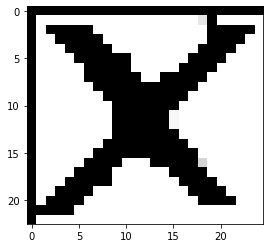

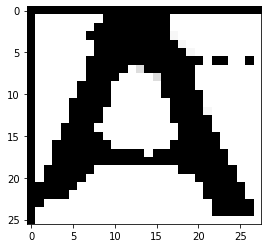

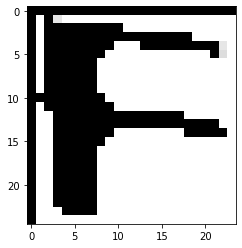

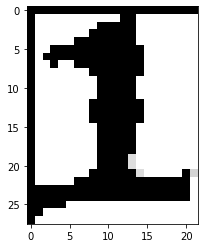

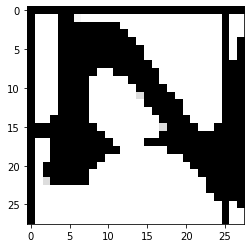

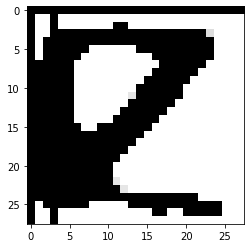

In [ ]:
for imag in images:
  plt.imshow(imag, cmap= 'gray')
  plt.show()

Por fim, todo o código descrito acima é convertido em funções, uma para remover o ruído desta e outra para identificar os boundig boxes das letras.

In [ ]:
 def processa_img(img):
  img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255,255,255])

  _ , img_tratada = cv2.threshold(img, 30,255,cv2.THRESH_TRUNC or cv2.THRESH_OTSU)

  blur = cv2.medianBlur(img_tratada, 3)

  image = cv2.blur(blur, (1, 1))
  ret, image = cv2.threshold(image, 90, 255, cv2.THRESH_TRUNC)
  element = cv2.getStructuringElement(cv2.MORPH_CROSS, (4,3))
  image = cv2.dilate(image, element)
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      if image[x][y] < 25:
        image[x][y] = 0
  #retorna img_tratada
  return image

def rectangles_list(img):

  contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  letter_image_regions = []
  list_temp = []

  for c in contours:
      rect = cv2.boundingRect(c)
      area = cv2.contourArea(c)

      if area > 115 and area < 3000:
        list_temp.append(rect)

  for c in list_temp:
      for d in list_temp:
        if c[0] < d[0] and c[0] + c[2] > d[0] + d[2]:
          list_temp.remove(d)


  for i in range(len(list_temp)):
      x, y, w, h = list_temp[i]

      if w > h*1.2:
        largura = int(w/(w/h))
        inicial = x

        for i in range(math.ceil(w/h)):
    
          letter_image_regions.append([inicial,y,largura,h])

          inicial += int(w/math.ceil(w/h))

      else:
        
        letter_image_regions.append([x, y , w, h])

  letter_image_regions = sorted(letter_image_regions, key = lambda x : x[0])

  indexes = np.ones(len(letter_image_regions))

  for i in range(1, len(letter_image_regions)):
    if i > 1 and i < len(letter_image_regions) -1:
      if letter_image_regions[i][0] < (letter_image_regions[i-1][0] + letter_image_regions[i-1][2]):
        if (letter_image_regions[i][0] + letter_image_regions[i][2]) > letter_image_regions[i+1][0]:
          letter_image_regions[i][0] = letter_image_regions[i-1][0] + letter_image_regions[i-1][2]
          letter_image_regions[i][2] = 30
        if letter_image_regions[i][0] + letter_image_regions[i][2] <= letter_image_regions[i-1][0] + letter_image_regions[i-1][2] \
            or letter_image_regions[i][2] <= 10 or letter_image_regions[i][0] + letter_image_regions[i][2] > 190:
          letter_image_regions.remove(letter_image_regions[i])
          indexes[i] = 0

  for i in range(1, len(letter_image_regions)):
    if i < len(letter_image_regions) -1:
      if letter_image_regions[i][0] > letter_image_regions[i+1][0]:
        letter_image_regions.remove(letter_image_regions[i+1])
        indexes[i] = 0
      if letter_image_regions[i][0] + letter_image_regions[i][2] <= letter_image_regions[i-1][0] + letter_image_regions[i-1][2] + 3 \
        or letter_image_regions[i][2] <= 10 or letter_image_regions[i][0] + letter_image_regions[i][2] > 190:
         letter_image_regions.remove(letter_image_regions[i])
         indexes[i] = 0

  indexes[len(letter_image_regions)-1:] = 0

  return letter_image_regions, indexes



# Divisão das imagens originais em regiões de interesse
As células a seguir pegam as imagens originais dos 3 grupos fornecidos e transformam-nas em apenas imagens das regiões que apresentam letras.

In [ ]:
for i in range(1, 8001):

  idx_img = str(i)
  idx_img = idx_img.zfill(6)
  image_name = PWD+"treinamento/"+idx_img+".jpg"

  imagem = cv2.imread(image_name,0)
  image = processa_img(imagem)
  letter_image_regions, indexes = rectangles_list(image)

  images = []

  for letter_bounding_box in letter_image_regions:

    x,y,w,h = letter_bounding_box

    letter_image = image[y : y+h , x : x+w]
    images.append(letter_image)
  
  
  label = PWD+"labels10k/" + idx_img + ".txt"
  f = open(label, "r")
  label_str = f.readline()
  k = 0
  for j in range(len(indexes)):
    if indexes[j] == 1:
      cv2.imwrite("/content/caracteres_treinamento/" + label_str[k] + "/" + idx_img + "_" + str(j) + ".png", images[j])
      k += 1
    if k == 6: break
  f.close()



In [ ]:
for i in range(8001, 9001):

  idx_img = str(i)
  idx_img = idx_img.zfill(6)
  image_name = PWD+"validacao/"+idx_img+".jpg"

  imagem = cv2.imread(image_name,0)
  image = processa_img(imagem)
  letter_image_regions, indexes = rectangles_list(image)

  images = []

  for letter_bounding_box in letter_image_regions:

    x,y,w,h = letter_bounding_box

    letter_image = image[y : y+h , x : x+w]
    images.append(letter_image)
  
  
  label = PWD+"labels10k/" + idx_img + ".txt"
  f = open(label, "r")
  label_str = f.readline()
  k = 0
  for j in range(len(indexes)):
    if indexes[j] == 1:
      cv2.imwrite("/content/caracteres_validacao/" + label_str[k] + "/" + idx_img + "_" + str(j) + ".png", images[j])
      k += 1
    if k == 6: break
  f.close()

In [ ]:
for i in range(9001, 10001):

  idx_img = str(i)
  idx_img = idx_img.zfill(6)
  image_name = PWD+"teste/"+idx_img+".jpg"

  imagem = cv2.imread(image_name,0)
  image = processa_img(imagem)
  letter_image_regions, indexes = rectangles_list(image)

  images = []

  for letter_bounding_box in letter_image_regions:

    x,y,w,h = letter_bounding_box

    letter_image = image[y : y+h , x : x+w]
    images.append(letter_image)
  
  
  label = PWD+"labels10k/" + idx_img + ".txt"
  f = open(label, "r")
  label_str = f.readline()
  k = 0
  for j in range(len(indexes)):
    if indexes[j] == 1:
      cv2.imwrite("/content/caracteres_teste/" + label_str[k] + "/" + idx_img + "_" + str(j) + ".png", images[j])
      k += 1
    if k == 6: break
  f.close()

# Preparação dos dados para o treinamento
Como letras são dados do tipo categórico e não existem relações entre os valores de duas letras, estas não podem ser usadas para o treinamento do modelo. \\
\
Como solução a isso, as letras foram passaram por um one hot encoding, tornando-se vetores onde cada posição representa uma letra. \\
\
Com a nova forma de representar as saídas definidas, os dados são carregados em matrizes, as quais serão passadas como parâmetro para o treinamento.

In [ ]:
def char_1hot_enconding(char):
  one_hot_enconding = np.zeros(36)
  if ord(char) >= 65:
    one_hot_enconding[ord(char) - 65] = 1
  else:
    one_hot_enconding[ord(char) - 48 + 26] = 1
  return one_hot_enconding

def encoding_to_char(enconding):
  char = np.argmax(enconding)
  if char < 26:
    return chr(char + 65)
  else:
    return chr(char + 48 - 26)

In [ ]:
letter_folder = "caracteres_treinamento/"

#imagens
train_data = []

#labels -> caracteres em texto
train_labels = []

for image in paths.list_images(letter_folder):
  
  #lendo img
  img = cv2.imread(image) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img,(30,30))

  #adicionando uma 3a dimensao na img(necessario para o Keras)
  img = np.expand_dims(img, axis= 2)

  #atribuindo a letra
  label = image.split(os.path.sep)[-2]


  train_data.append(img)
  train_labels.append(char_1hot_enconding(label))

#convertendo em np array

train_data = np.array(train_data, dtype = 'float')
train_labels = np.array(train_labels)

print(train_data.shape, train_labels.shape)


(37613, 30, 30, 1) (37613, 36)


In [ ]:
letter_folder = "caracteres_validacao/"

#imagens
val_data = []

#labels -> caracteres em texto
val_labels = []

for image in paths.list_images(letter_folder):
  
  #lendo img
  img = cv2.imread(image) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img,(30,30))

  #adicionando uma 3a dimensao na img(necessario para o Keras)
  img = np.expand_dims(img, axis= 2)

  #atribuindo a letra
  label = image.split(os.path.sep)[-2]

  val_data.append(img)
  val_labels.append(char_1hot_enconding(label))
#convertendo em np array

val_data = np.array(val_data, dtype = 'float')
val_labels = np.array(val_labels)

print(val_data.shape, val_labels.shape)

(4670, 30, 30, 1) (4670, 36)


In [ ]:
letter_folder = "caracteres_teste/"

#imagens
test_data = []

#labels -> caracteres em texto
test_labels = []

for image in paths.list_images(letter_folder):
  
  #lendo img
  img = cv2.imread(image) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img,(30,30))

  #adicionando uma 3a dimensao na img(necessario para o Keras)
  img = np.expand_dims(img, axis= 2)

  #atribuindo a letra
  label = image.split(os.path.sep)[-2]

  test_data.append(img)
  test_labels.append(char_1hot_enconding(label))
#convertendo em np array

test_data = np.array(test_data, dtype = 'float')
test_labels = np.array(test_labels)

print(test_data.shape, test_labels.shape)

(4693, 30, 30, 1) (4693, 36)


# A Rede Neural Convolucional
A rede é composta por duas camadas convolucionais e duas camadas fully connected. Após cada camada convolucional é chamado o MaxPooling, para que o modelo capture informações mais globais da imagem. Em diversos momentos do treinamento também é chamada a função dropout, para evitar que ocorra overfitting.

In [ ]:
# Inicializando o modelo
classifier = Sequential()

# Adciona uma camada de convolucoes em 2D usando relu como funcao de ativacao
classifier.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(30,30,1)))
# Realiza um MaxPool em blocos de 2x2
classifier.add(MaxPooling2D(pool_size=(2,2)))
# Adciona um dropout para evitar overfitting
classifier.add(Dropout(.2))

classifier.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(.2))

# Cria a camada densa da CNN com 128 neuronios e relu como funcao de ativacao
classifier.add(Flatten())
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(.2))

# Realiza o softmax para extrair a classe
classifier.add(Dense(units=36, activation='softmax'))

# Compila o modelo
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'], run_eagerly=True)

In [ ]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

Após a definição do modelo, este é treinado, com o uso dos dados de treinamento fornecido, para o ajuste dos parâmetros, e os dados de validação para acompanhar o treinamento, garantindo que não ocorra overfitting.

In [ ]:
classifier.fit(x = train_data, y = train_labels, validation_data=(val_data, val_labels), batch_size = 128, epochs = 10, verbose = 1, use_multiprocessing=True)

Epoch 1/10
294/294 [==============================] - 166s 562ms/step - loss: 2.1686 - accuracy: 0.4672 - val_loss: 1.4801 - val_accuracy: 0.6649
Epoch 2/10
294/294 [==============================] - 166s 565ms/step - loss: 1.3349 - accuracy: 0.6953 - val_loss: 1.3052 - val_accuracy: 0.7208
Epoch 3/10
294/294 [==============================] - 164s 558ms/step - loss: 1.1810 - accuracy: 0.7362 - val_loss: 1.2386 - val_accuracy: 0.7388
Epoch 4/10
294/294 [==============================] - 162s 550ms/step - loss: 1.0844 - accuracy: 0.7582 - val_loss: 1.2297 - val_accuracy: 0.7390
Epoch 5/10
294/294 [==============================] - 167s 568ms/step - loss: 1.0119 - accuracy: 0.7713 - val_loss: 1.2150 - val_accuracy: 0.7505
Epoch 6/10
294/294 [==============================] - 160s 546ms/step - loss: 0.9650 - accuracy: 0.7827 - val_loss: 1.2006 - val_accuracy: 0.7499
Epoch 7/10
294/294 [==============================] - 162s 551ms/step - loss: 0.9099 - accuracy: 0.7926 - val_loss: 1.1911 -

# Análise experimental
Essa seção cobre o desempenho do modelo, mostrando dados sobre seu comportamento para cada uma das classes e, de forma mais genérica, como ele desempenhou com o captcha em geral.

147/147 [==============================] - 6s 42ms/step


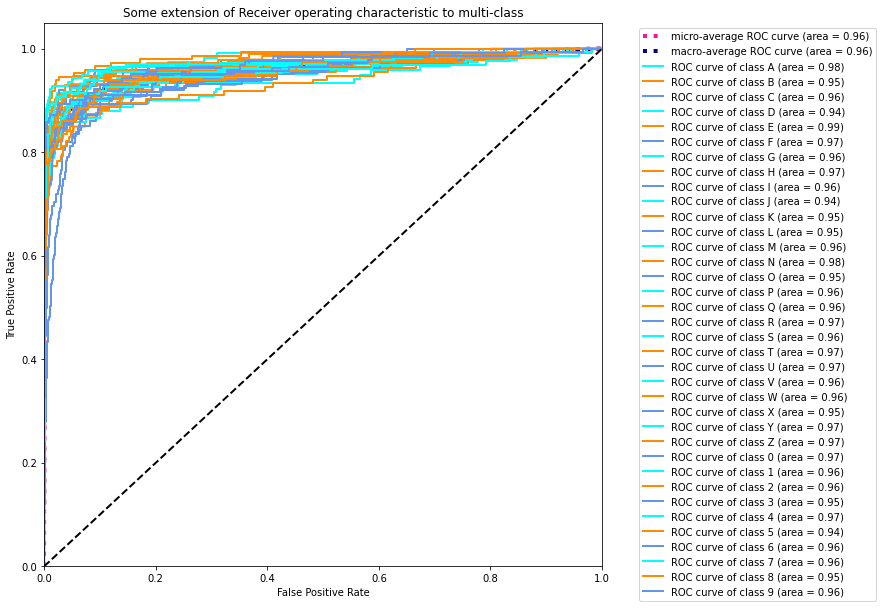

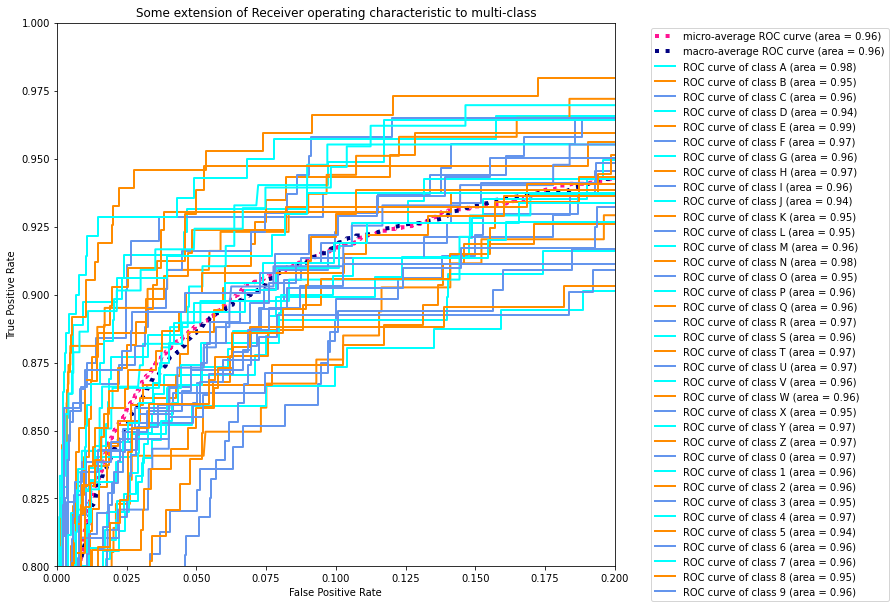

In [ ]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc

classes = []

for j in range(36):
  if j < 26:
    classes.append(chr(j+65))
  else:
    classes.append(chr(j+48-26))

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 36

labels_pred = classifier.predict(test_data)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], labels_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), labels_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2, figsize=(10,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right")
plt.show()

In [ ]:
labels_pred = classifier.predict(test_data, batch_size=32, verbose=1)

147/147 [==============================] - 6s 41ms/step


In [ ]:
labels_pred_bool = np.argmax(labels_pred, axis=1)
test_labels_bool = np.argmax(test_labels, axis=1)
print(classification_report(test_labels_bool, labels_pred_bool, target_names=classes))

              precision    recall  f1-score   support

           A       0.84      0.87      0.85       117
           B       0.81      0.72      0.76       113
           C       0.59      0.66      0.63       128
           D       0.66      0.77      0.71       142
           E       0.84      0.89      0.86       148
           F       0.74      0.84      0.79       112
           G       0.71      0.77      0.74       139
           H       0.82      0.76      0.79       123
           I       0.78      0.80      0.79       127
           J       0.69      0.78      0.74       119
           K       0.77      0.81      0.79       135
           L       0.80      0.75      0.78       132
           M       0.84      0.73      0.78       127
           N       0.86      0.87      0.86       143
           O       0.49      0.56      0.52       143
           P       0.79      0.82      0.81       122
           Q       0.63      0.75      0.68       106
           R       0.84    

A célula a seguir declara uma função que recebe um índice, o qual representa uma das imagens do grupo de teste, e retorna o número de acertos na previsão, qual a string predita, qual a string verdadeira e a imagem original, sem nenhuma remoção de ruído.

In [ ]:
def test_pred_diff(idx):

  idx_img = str(idx+9001)
  idx_img = idx_img.zfill(6)
  image_name = PWD+"teste/"+idx_img+".jpg"

  img = cv2.imread(image_name, 0)

  image = processa_img(img)
  letter_image_regions, indexes = rectangles_list(image)

  images = []

  for letter_bounding_box in letter_image_regions:

    x,y,w,h = letter_bounding_box

    letter_image = image[y : y+h , x : x+w]
    images.append(letter_image)


  label = PWD+"labels10k/" + idx_img + ".txt"
  f = open(label, "r")
  label_str = f.readline()
  f.close()
  predicted_str = ""

  data = []

  for i in images:
    i = cv2.resize(i,(30,30))
    i = np.expand_dims(i, axis= 2)
    data.append(i)

  data = np.array(data)

  encoding = classifier.predict(data, verbose=0)

  for enc in encoding:
    predicted_str += encoding_to_char(enc)
  
  count_acertos = 0
  for j in range(min(len(predicted_str), len(label_str))):
    if predicted_str[j] == label_str[j]:
      count_acertos+=1

  return count_acertos, img, predicted_str, label_str

Num acertos:  5
Predicted string:  C921Z1
Actual string:  C921ZU



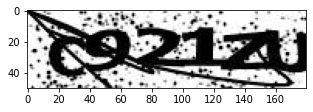

In [ ]:
acertos, img, pred_str, label = test_pred_diff(999)

print("Num acertos: ", acertos)
print("Predicted string: ", pred_str)
print("Actual string: ", label)
plt.imshow(img, cmap='gray')

In [ ]:
hist = np.zeros(7)

for idx in range(1,1000):

  if idx != 863:

    acertos, img, pred_str, label = test_pred_diff(idx)
    
    if(acertos == 0):
      hist[0] += 1
    
    elif(acertos == 1):
      hist[0] += 1
      hist[1] += 1
    
    elif(acertos == 2):
      hist[0] += 1
      hist[1] += 1
      hist[2] += 1
    
    elif(acertos == 3):
      hist[0] += 1
      hist[1] += 1
      hist[2] += 1
      hist[3] += 1
    
    elif(acertos == 4):
      hist[0] += 1
      hist[1] += 1
      hist[2] += 1
      hist[3] += 1
      hist[4] += 1
    
    elif(acertos == 5):
      hist[0] += 1
      hist[1] += 1
      hist[2] += 1
      hist[3] += 1
      hist[4] += 1
      hist[5] += 1
    
    elif(acertos == 6):
      hist[0] += 1
      hist[1] += 1
      hist[2] += 1
      hist[3] += 1
      hist[4] += 1
      hist[5] += 1
      hist[6] += 1
    



O gráfico abaixo apresenta a quantidade de caracteres reconhecidos corretamente em cada captcha.

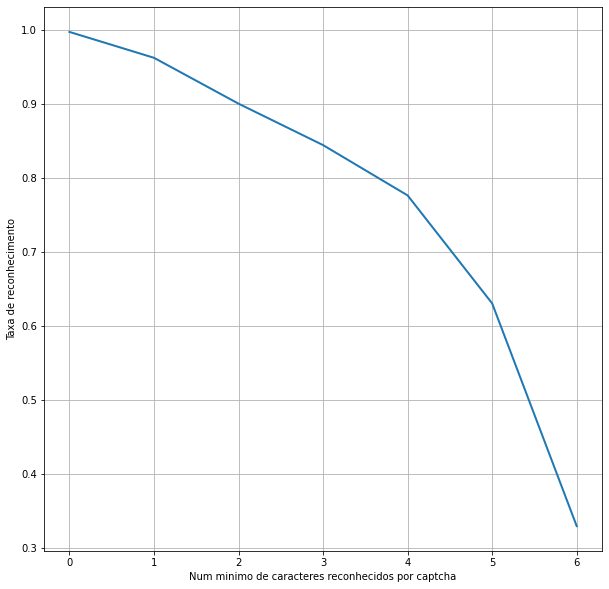

In [ ]:

x = np.arange(0,7)

plt.rcParams["figure.figsize"] = (10,10)

plt.plot(x, hist/1000, linewidth=2, markersize=12)
plt.grid()
plt.xlabel("Num minimo de caracteres reconhecidos por captcha")
plt.ylabel("Taxa de reconhecimento")

plt.show()

#Plot de 50 CAPTCHAS
Nesta seção pode-se ver as imagens originais e quais foram as previsões realizadas sobre ela pelo modelo. É importante observar que todas estas imagens foram retiradas do conjunto de teste.

In [ ]:
import random

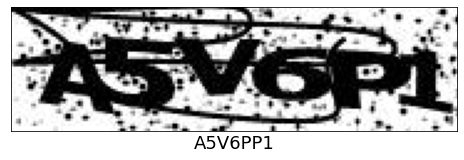

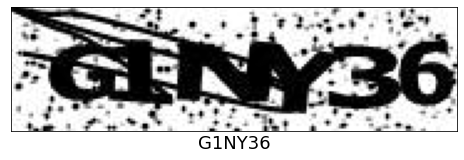

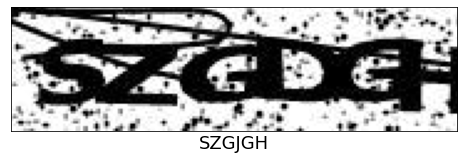

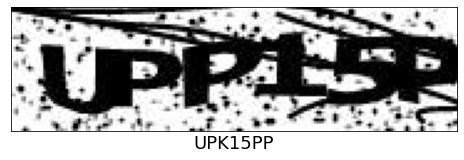

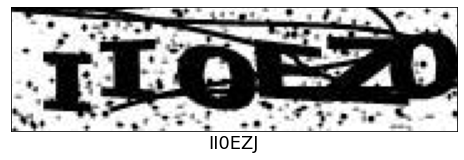

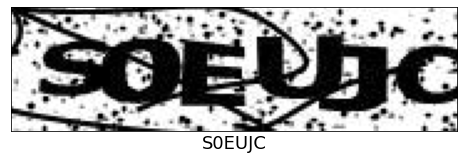

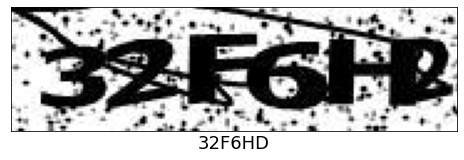

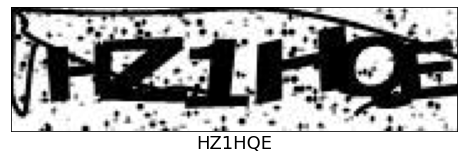

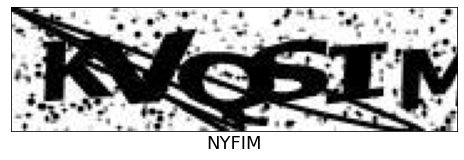

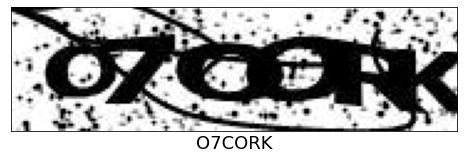

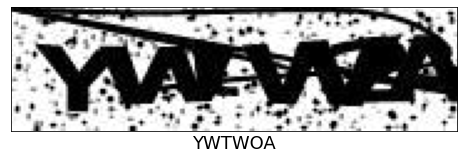

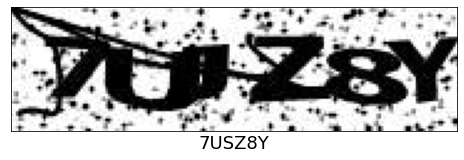

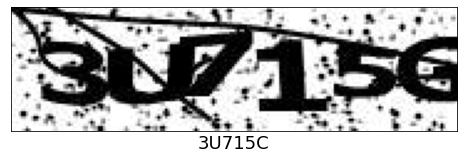

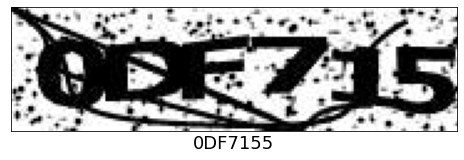

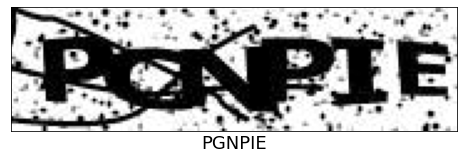

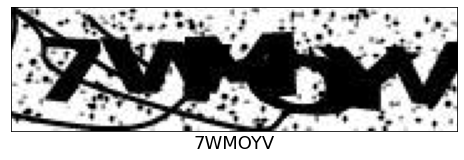

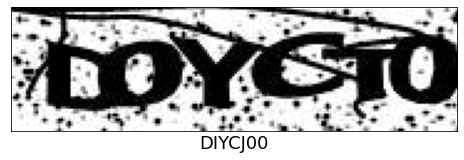

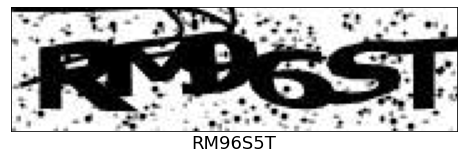

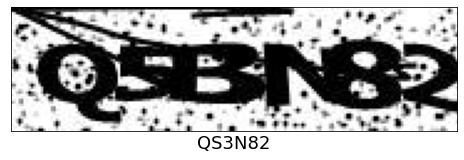

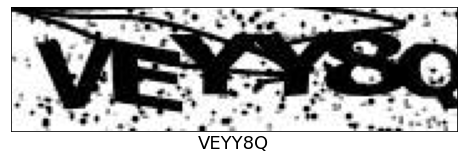

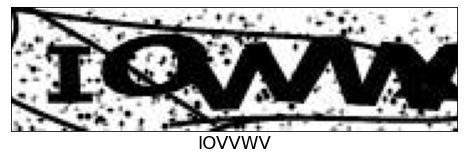

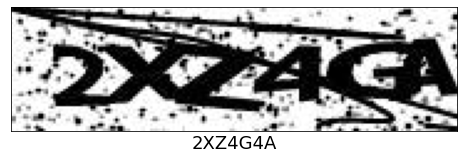

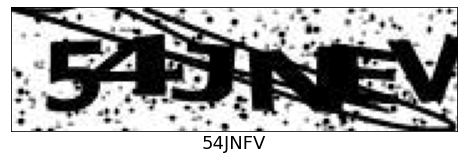

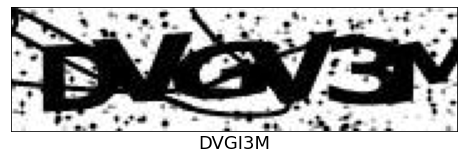

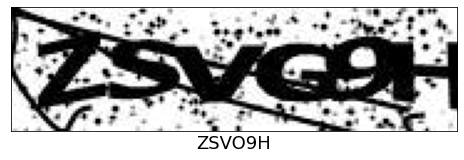

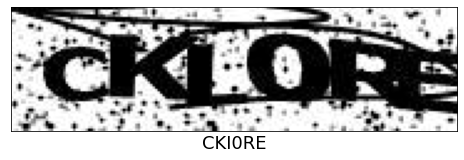

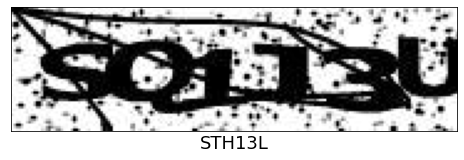

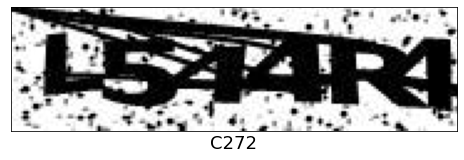

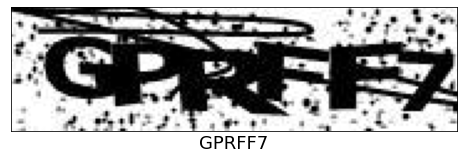

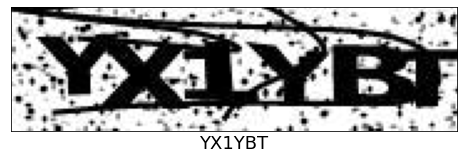

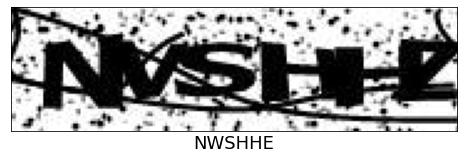

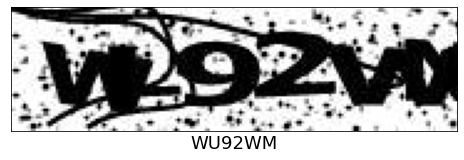

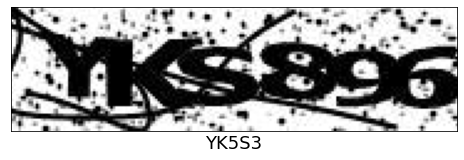

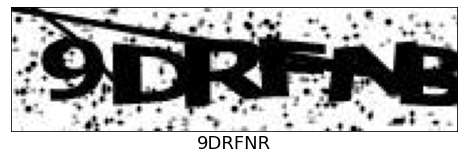

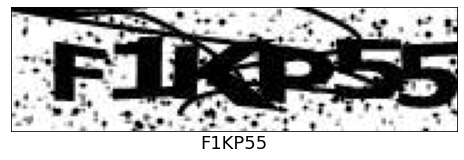

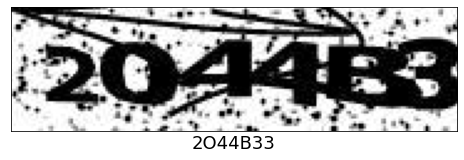

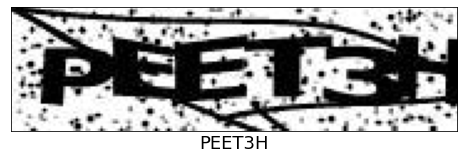

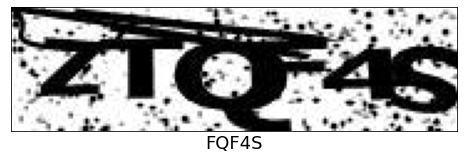

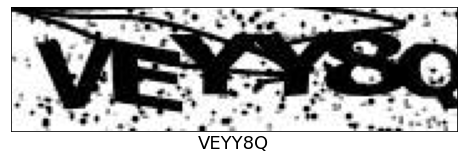

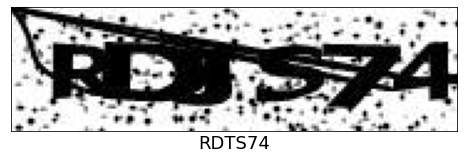

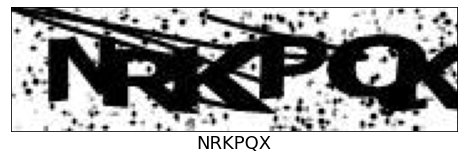

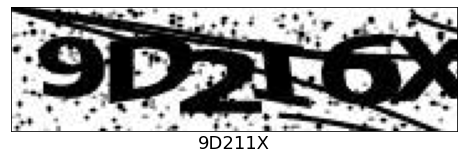

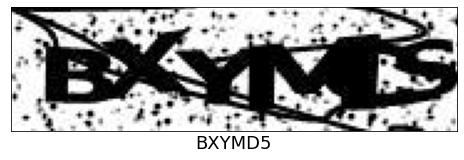

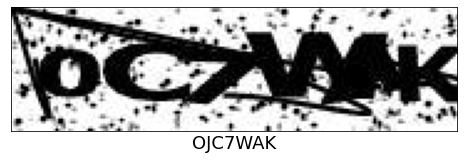

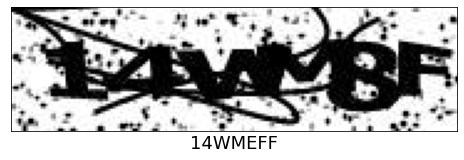

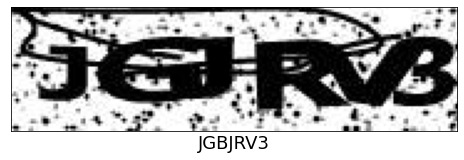

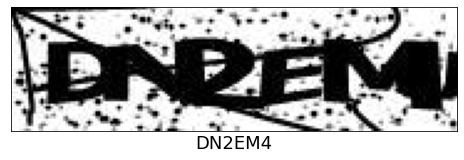

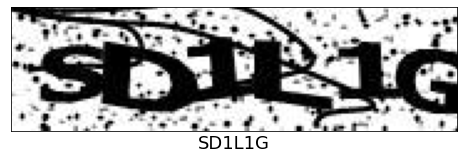

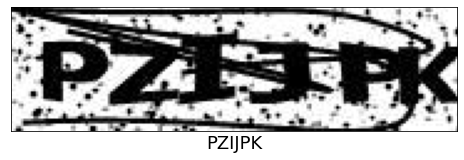

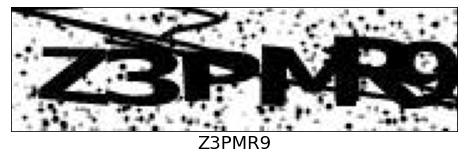

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)


for _ in range(50):
  idx = random.randrange(1, 1000)
  if idx != 863 :

    acertos, img, pred_str, label = test_pred_diff(idx)

    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(pred_str, fontsize = 18)

    plt.show()
  